## Analyzing MW articles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import string
from datetime import datetime
import re
import pickle
from functools import reduce
from collections import Counter
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from pytrends.request import TrendReq
import seaborn as sns
import itertools
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf


%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('precision', 3)

In [3]:
with open('/Users/samfunk/ds/metis/project_luther/links.pkl', 'rb') as f:
    links = pickle.load(f)

df = pd.DataFrame()

dictlist = [x for x in links.items()]

df['article'] = [x[0].lower() for x in dictlist]
df['datetime'] = [x[1]['date'] for x in dictlist]
df['url'] = [x[1]['url'] for x in dictlist]

regex = re.compile('[%s]' % re.escape(string.punctuation.replace(':', '')))
df['datetime'] = df['datetime'].apply(lambda x: regex.sub('', x))

df['time'] = df['datetime'].apply(lambda x: re.search(r'^(.+?\s.+?)\s', x)[1])
df['time_string'] = df['time'].apply(lambda x: datetime.strptime(x, '%I:%M %p').time())

df['date'] = df['datetime'].apply(lambda x: re.search(r'([A-Z].*)', x)[1])
df['date'] = df['date'].apply(lambda x: re.sub(r'([A-Za-z]{3})[a-z]*', r'\1', x))
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%b %d %Y'))
df['date_string'] = df['date'].apply(lambda x: x.date())

#df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, '%b %d %Y %I:%M %p'))

df['datetime'] = df.apply(lambda x: datetime.combine(x['date_string'], x['time_string']), axis=1)

df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.weekday())

df['url'] = df['url'].apply(lambda x: 'http://marketwatch.com' + x if 'http' not in x else x)

df = df.sort_values('datetime')

#df = df['06-01-2017':]
df = df[(df['month'] > 5) & (df['month'] < 10)]
df = df[df['day'] < 5]

df_links = df.copy()

In [4]:
len(df)

10066

In [5]:
pickles = ['econ', 'fed', 'strong', 'soft']

for p in pickles:
    with open('/Users/samfunk/ds/metis/project_luther/' + p + '.pkl', 'rb') as f:
        globals()[str(p)] = pickle.load(f)

In [6]:
def to_df(dictfile, colname):
    
    df = pd.DataFrame()
    
    try:
        dictlist = [x for x in dictfile.items()]
    except:
        dictlist = dictfile

    df['article'] = [x[0].lower() for x in dictlist]
    df['datetime'] = [x[1]['date'] for x in dictlist]
    df['url'] = [x[1]['url'] for x in dictlist]
    df[colname] = 1
    
    regex = re.compile('[%s]' % re.escape(string.punctuation.replace(':', '')))
    df['datetime'] = df['datetime'].apply(lambda x: regex.sub('', x))

    df['time'] = df['datetime'].apply(lambda x: re.search(r'^(.+?\s.+?)\s', x)[1])
    df['time_string'] = df['time'].apply(lambda x: datetime.strptime(x, '%I:%M %p').time())

    df['date'] = df['datetime'].apply(lambda x: re.search(r'([A-Z].*)', x)[1])
    df['date'] = df['date'].apply(lambda x: re.sub(r'([A-Za-z]{3})[a-z]*', r'\1', x))
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%b %d %Y'))
    df['date_string'] = df['date'].apply(lambda x: x.date())

    #df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, '%b %d %Y %I:%M %p'))

    df['datetime'] = df.apply(lambda x: datetime.combine(x['date_string'], x['time_string']), axis=1)

    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['day'] = df['datetime'].apply(lambda x: x.weekday())

    df['url'] = df['url'].apply(lambda x: 'http://marketwatch.com' + x if 'http' not in x else x)
    
    df = df.sort_values('datetime')
    
    #df = df['06-01-2017':]
    df = df[(df['month'] > 5) & (df['month'] < 10)]
    df = df[df['day'] < 5]

    return df.copy()
    

In [7]:
df_econ = to_df(econ, 'econ')
df_fed = to_df(fed, 'fed')
df_strong = to_df(strong, 'strong')
df_soft = to_df(soft, 'soft')
data = [df_links, df_econ, df_fed, df_strong, df_soft]

In [8]:
master = pd.concat(data, ignore_index=True)

In [9]:
master.shape

(11992, 13)

In [10]:
c = Counter(master.datetime)
dups = [n for n in c if c[n] > 1]
mask = master.datetime.isin(dups)
result = master.loc[(~mask) | ((mask) & (master.econ > 0)) | ((mask) & (master.fed > 0)) | ((mask) & (master.strong > 0)) | ((mask) & (master.soft > 0)), :]

master = result.drop_duplicates()

In [11]:
master = master.fillna(0)
master = master[master['date'] != '2016-07-08']

In [12]:
count = master.groupby('date')['article'].count().reset_index().set_index('date')
sums = master.groupby('date')['econ', 'fed', 'strong', 'soft'].sum().reset_index().set_index('date')
master = sums.join(count, how='left')

In [13]:
master['econ_day'] = master['econ'] / master['article']
master['strong_day'] = master['strong'] / master['article']
master['strong_soft'] = master['strong'] + master['soft']
master['ss_day'] = master['strong_soft'] / master['article']

master['strong_econ'] = master['strong'] / master['econ']
master['ss_econ'] = master['strong_soft'] / master['econ']

In [14]:
master.shape

(87, 11)

## Read in Fed calendar data

In [15]:
with open('/Users/samfunk/ds/metis/project_luther/calendar.pkl', 'rb') as f:
    calendar = pickle.load(f)


In [16]:
calendar = calendar.groupby(calendar.index).first().reset_index().set_index('date')

In [17]:
master.shape

(87, 11)

In [18]:
master = master.join(calendar, how='left')
master = master.fillna(0)

## Read in Google Trends data

In [19]:
with open('/Users/samfunk/ds/metis/project_luther/trends.pkl', 'rb') as f:
    trends = pickle.load(f)

In [20]:
trends.rename(columns={'lag1': 'trend_lag1', 'lag2': 'trend_lag2', 'federal reserve': 'federal_reserve', 'unemployment rate': 'unemployment'}, inplace=True)

In [21]:
trends.shape

(87, 7)

In [22]:
master = master.join(trends, how='left')

In [23]:
master.shape

(87, 23)

## Read in SPX data

In [24]:
spx = pd.read_csv('/Users/samfunk/Downloads/GSPC.csv')

In [25]:
spx['Date'] = spx['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
spx = spx.sort_values(by='Date').set_index('Date')

spx = spx['06-01-2017':'10-02-2017']

spx['lag1'] = spx['Close'].diff()
spx['perc_change'] = spx['Close'].diff() / spx['Close'].shift()

In [26]:
spx = spx[['Close', 'lag1', 'perc_change']]

In [27]:
spx.shape

(85, 3)

In [28]:
master = master.join(spx, how='left')
master = master[np.isfinite(master.lag1)]

In [29]:
master.rename(columns={'lag1': 'spx_lag', 'Close': 'close'}, inplace=True)

In [30]:
master['abs_lag'] = master['spx_lag'].apply(lambda x: abs(x))

In [31]:
master.shape

(84, 27)

## Make correlation pairplots for different datasets vs. spx

In [ ]:
cal = master.loc[:, ['fomc', 'releases', 'speeches', 'abs_lag']]

In [ ]:
sns.pairplot(cal);

In [ ]:
google = master.loc[:, ['weighted', 'trend_lag1', 'abs_lag', 'spx_lag']]

In [ ]:
sns.pairplot(google);

In [ ]:
master

In [ ]:
mw = master.loc[:, ['strong_day', 'strong_soft', 'ss_day', 'strong_econ', 'ss_econ', 'squared', 'spx_lag', 'abs_lag']]

In [ ]:
sns.pairplot(mw);

### Main features correlations

In [ ]:
test = master.loc[:, ['ss_econ', 'weighted', 'releases', 'spx_lag']]
sns.pairplot(test)
corr = test.corr()
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
cbar = plt.colorbar()
plt.grid(False)
plt.yticks(np.arange(corr.shape[1]))
plt.xticks(np.arange(corr.shape[0])-0.5, rotation=45)
ax.set_xticklabels(list(test.columns), minor=False)
ax.set_yticklabels(list(test.columns), minor=False);

## Feature engineering

In [32]:
master['ss_econ_sq'] = master['ss_econ']**2
master['ss_day_sq'] = master['ss_day']**2
master['weighted_sq'] = master['weighted']**2
master['releases_sq'] = master['releases']**2

master['ss_econ_log'] = master['ss_econ'].apply(lambda x: np.log(x))
master['weighted_log'] = master['weighted'].apply(lambda x: np.log(x))
master['ss_day_log'] = master['ss_day'].apply(lambda x: np.log(x))

master['ss_econ_sqrt'] = master['ss_econ']**0.5
master['ss_day_sqrt'] = master['ss_day']**0.5
master['weighted_sqrt'] = master['weighted']**0.5
master['releases_sqrt'] = master['releases']**0.5

In [111]:
feature_set1 = master.loc[:, 'ss_econ_sq':]

In [112]:
feature_set1.shape

(84, 11)

In [113]:
cols = master.loc[:, ['ss_day', 'ss_econ', 'releases', 'weighted']]

In [114]:
cols.shape

(84, 4)

In [115]:
feature_set1 = feature_set1.join(cols, how='left')

In [116]:
feature_set1 = feature_set1.join(master.spx_lag, how='right')

In [117]:
feature_set1 = feature_set1.join(master.abs_lag, how='right')

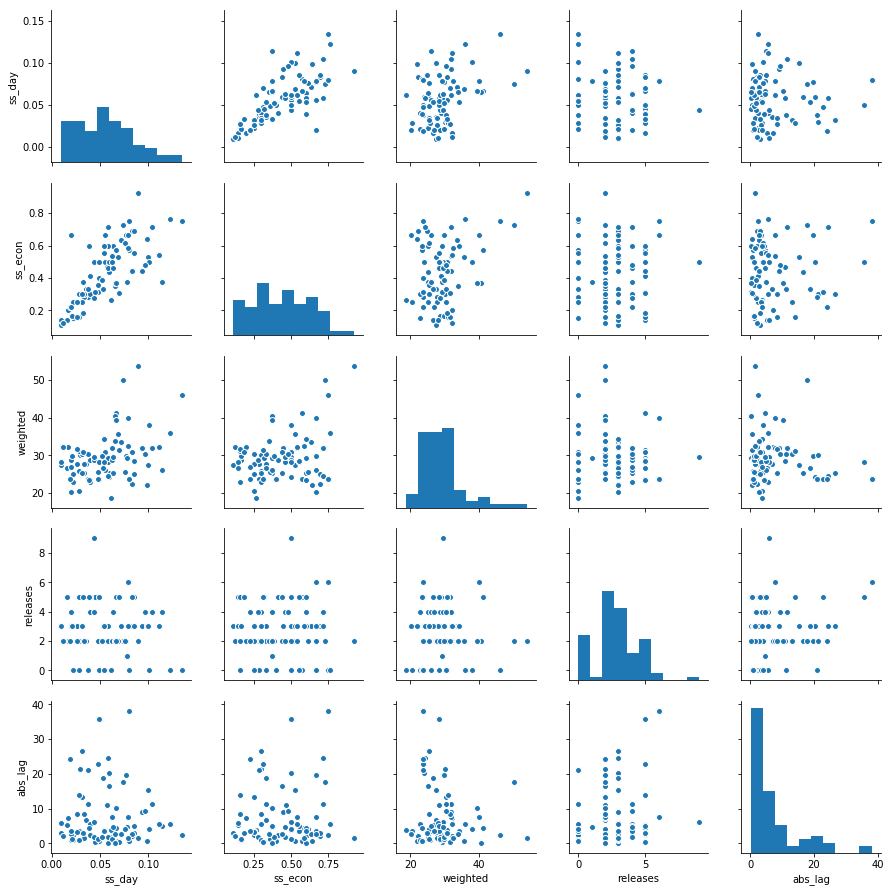

In [77]:
sns.pairplot(feature_set1.loc[:, ['ss_day', 'ss_econ', 'weighted', 'releases', 'abs_lag']]);

In [ ]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'spx_lag', 'abs_lag']])

In [ ]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_log', 'ss_day_log', 'weighted_log', 'spx_lag', 'abs_lag']])

In [ ]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sqrt', 'ss_day_sqrt', 'weighted_sqrt', 'releases_sqrt', 'spx_lag', 'abs_lag']])

In [ ]:
sns.pairplot(feature_set1.loc[:, ['ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'spx_lag', 'abs_lag']])

In [ ]:
features = ['ss_day', 'ss_econ', 'weighted', 'releases', 'ss_econ_sq', 'ss_day_sq', 'weighted_sq', 'releases_sq', 'ss_econ_log', 'ss_day_log', 'weighted_log', 'ss_econ_sqrt', 'ss_day_sqrt', 'weighted_sqrt', 'releases_sqrt']

In [140]:
coeffs = []
mse = []
intercepts = []
alpha = []
score = []
for comb in itertools.product(ssd, sse, rel, wei):
    X = np.array(shuffle.loc[:, list(comb)])
    y = np.array(shuffle.loc[:, ['spx_lag']])
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)
    
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_std = ss.transform(X_train)
    X_test_std = ss.transform(X_test)


    #ssX = StandardScaler()
    #ssX.fit(X)
    #X_std = ss.transform(X)
    
    model = Lasso(max_iter=5000)
    parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
    grid = GridSearchCV(model, parameters, cv=5, scoring=make_scorer(mean_squared_error), n_jobs=1)
    grid.fit(X_train_std, Y_train)
    
    coeffs.append(grid.best_estimator_.coef_)
    intercepts.append(grid.best_estimator_.intercept_ )
    alpha.append(grid.best_estimator_.alpha)
    
    best_lasso = grid.best_estimator_
    lasso_pred = best_lasso.predict(X_test_std)
    resid = 0
    for true, pred in zip(Y_test, lasso_pred):
        resid += (true - pred)**2
        
    
    mse.append(resid / len(lasso_pred))

In [141]:
for x,y,z,a,b in zip(itertools.product(sse, ssd, rel, wei), mse, coeffs, intercepts, alpha):
    if y < 50:
        print(x,y,z,a,b)

('ss_econ', 'ss_day', 'releases_sqrt', 'weighted_sq') [ 37.57056892] [-0.2159053  -1.19168313 -1.05813238  2.66015976] [ 1.129103] 1e-05
('ss_econ_sq', 'ss_day', 'releases_sq', 'weighted') [ 30.34250825] [-0.71766806 -0.40446786 -2.77147144  2.26511619] 0.0 1e-05
('ss_econ_sq', 'ss_day', 'releases_sqrt', 'weighted') [ 16.53874621] [-0.34452054 -1.1879997  -1.34785488  2.28182233] [ 1.03910622] 1e-05


In [118]:
sse = ['ss_econ', 'ss_econ_sq', 'ss_econ_sqrt']
ssd = ['ss_day', 'ss_day_sq', 'ss_day_sqrt']
rel = ['releases', 'releases_sq', 'releases_sqrt']
wei = ['weighted', 'weighted_sq', 'weighted_sqrt']
prod = ['ss_prod', 'sse_rel', 'sse_wei', 'ssd_rel', 'ssd_wei', 'rel_wei']

In [119]:
feature_set1['ss_prod'] = feature_set1['ss_econ'] * feature_set1['ss_day']
feature_set1['sse_rel'] = feature_set1['ss_econ'] * feature_set1['releases']
feature_set1['sse_wei'] = feature_set1['ss_econ'] * feature_set1['weighted']
feature_set1['ssd_rel'] = feature_set1['ss_day'] * feature_set1['releases']
feature_set1['ssd_wei'] = feature_set1['ss_day'] * feature_set1['weighted']
feature_set1['rel_wei'] = feature_set1['releases'] / feature_set1['weighted']

In [121]:
feature_set1

,ss_econ_sq,ss_day_sq,weighted_sq,releases_sq,ss_econ_log,weighted_log,ss_day_log,ss_econ_sqrt,ss_day_sqrt,weighted_sqrt,releases_sqrt,ss_day,ss_econ,releases,weighted,spx_lag,abs_lag,ss_prod,sse_rel,sse_wei,ssd_rel,ssd_wei,rel_wei
date,,,,,,,,,,,,,,,,,,,,,,,
2017-06-02,0.198,8.653e-03,1020.803,9.0,-0.811,3.464,-2.375,0.667,0.305,5.652,1.732,0.093,0.444,3.0,31.95,9.01,9.01,0.041,1.333,14.200,0.279,2.972,0.094
2017-06-05,0.012,8.573e-05,750.760,9.0,-2.197,3.311,-4.682,0.333,0.096,5.235,1.732,0.009,0.111,3.0,27.40,-2.97,2.97,0.001,0.333,3.044,0.028,0.254,0.109
2017-06-06,0.111,1.231e-03,761.760,4.0,-1.099,3.318,-3.350,0.577,0.187,5.254,1.414,0.035,0.333,2.0,27.60,-6.77,6.77,0.012,0.667,9.200,0.070,0.968,0.072
2017-06-07,0.250,3.086e-03,945.562,0.0,-0.693,3.426,-2.890,0.707,0.236,5.545,0.000,0.056,0.500,0.0,30.75,3.81,3.81,0.028,0.000,15.375,0.000,1.708,0.000
2017-06-08,0.160,2.419e-03,559.322,0.0,-0.916,3.163,-3.012,0.632,0.222,4.863,0.000,0.049,0.400,0.0,23.65,0.65,0.65,0.020,0.000,9.460,0.000,1.163,0.000
2017-06-09,0.479,6.944e-03,495.062,9.0,-0.368,3.102,-2.485,0.832,0.289,4.717,1.732,0.083,0.692,3.0,22.25,-2.02,2.02,0.058,2.077,15.404,0.250,1.854,0.135
2017-06-12,0.062,4.726e-04,627.503,9.0,-1.386,3.221,-3.829,0.500,0.147,5.005,1.732,0.022,0.250,3.0,25.05,-2.38,2.38,0.005,0.750,6.263,0.065,0.545,0.120
2017-06-13,0.218,3.292e-03,803.723,4.0,-0.762,3.345,-2.858,0.683,0.240,5.324,1.414,0.057,0.467,2.0,28.35,10.96,10.96,0.027,0.933,13.230,0.115,1.627,0.071
2017-06-14,0.562,1.804e-02,2129.823,0.0,-0.288,3.832,-2.007,0.866,0.367,6.793,0.000,0.134,0.750,0.0,46.15,-2.43,2.43,0.101,0.000,34.613,0.000,6.199,0.000


## Shuffle data and train/test

In [142]:
np.random.seed(42)
shuffle = feature_set1.sample(frac=1)

In [123]:
shuffle

,ss_econ_sq,ss_day_sq,weighted_sq,releases_sq,ss_econ_log,weighted_log,ss_day_log,ss_econ_sqrt,ss_day_sqrt,weighted_sqrt,releases_sqrt,ss_day,ss_econ,releases,weighted,spx_lag,abs_lag,ss_prod,sse_rel,sse_wei,ssd_rel,ssd_wei,rel_wei
date,,,,,,,,,,,,,,,,,,,,,,,
2017-09-15,0.213,3.989e-03,870.250,16.0,-0.773,3.384,-2.762,0.679,0.251,5.431,2.000,0.063,0.462,4.0,29.50,4.61,4.61,0.029,1.846,13.615,0.253,1.863,0.136
2017-06-02,0.198,8.653e-03,1020.803,9.0,-0.811,3.464,-2.375,0.667,0.305,5.652,1.732,0.093,0.444,3.0,31.95,9.01,9.01,0.041,1.333,14.200,0.279,2.972,0.094
2017-08-24,0.309,7.182e-03,806.560,25.0,-0.588,3.346,-2.468,0.745,0.291,5.329,2.236,0.085,0.556,5.0,28.40,-5.07,5.07,0.047,2.778,15.778,0.424,2.407,0.176
2017-07-05,0.444,3.030e-03,681.210,0.0,-0.405,3.262,-2.900,0.816,0.235,5.109,0.000,0.055,0.667,0.0,26.10,3.53,3.53,0.037,0.000,17.400,0.000,1.437,0.000
2017-06-20,0.191,3.460e-03,635.040,4.0,-0.827,3.227,-2.833,0.661,0.243,5.020,1.414,0.059,0.438,2.0,25.20,-16.43,16.43,0.026,0.875,11.025,0.118,1.482,0.079
2017-09-12,0.025,7.048e-04,998.560,4.0,-1.846,3.453,-3.629,0.397,0.163,5.621,1.414,0.027,0.158,2.0,31.60,8.37,8.37,0.004,0.316,4.989,0.053,0.839,0.063
2017-06-16,0.413,9.781e-03,484.000,9.0,-0.442,3.091,-2.314,0.802,0.314,4.690,1.732,0.099,0.643,3.0,22.00,0.69,0.69,0.064,1.929,14.143,0.297,2.176,0.136
2017-06-28,0.090,8.483e-04,903.002,4.0,-1.204,3.403,-3.536,0.548,0.171,5.482,1.414,0.029,0.300,2.0,30.05,21.31,21.31,0.009,0.600,9.015,0.058,0.875,0.067
2017-06-08,0.160,2.419e-03,559.322,0.0,-0.916,3.163,-3.012,0.632,0.222,4.863,0.000,0.049,0.400,0.0,23.65,0.65,0.65,0.020,0.000,9.460,0.000,1.163,0.000


### Standardize features for regularization (Test/Train and Unsplit)

In [206]:
X = np.array(shuffle.loc[:, ['ss_econ', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, 'abs_lag'])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)

ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)


ssX = StandardScaler()
ssX.fit(X)
X_std = ss.transform(X)

# LASSO with train/test split

In [207]:
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_train_std, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [208]:
grid.cv_results_

{'mean_fit_time': array([ 0.00046334,  0.00029664,  0.00036092,  0.00026999,  0.00029883,
         0.00022054,  0.00026593,  0.00021667,  0.0002604 ,  0.00021892]),
 'mean_score_time': array([ 0.00021205,  0.00016356,  0.00014038,  0.00014696,  0.00014725,
         0.0001267 ,  0.00013113,  0.00012598,  0.00012517,  0.00014567]),
 'mean_test_score': array([-6.86511553, -8.32487202, -6.86510516, -8.32481232, -6.86500129,
        -8.32421526, -6.86396724, -8.31825599, -6.85494905, -8.25866345]),
 'mean_train_score': array([-6.33012083, -7.97742785, -6.33010702, -7.97739545, -6.32996901,
        -7.97707132, -6.3285894 , -7.97383322, -6.31531825, -7.94417304]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True False True False True False],
              mask = [False

In [209]:
grid.best_estimator_.coef_

array([ 1.14792236,  1.83034471, -0.64162744])

In [210]:
grid.best_estimator_.intercept_


7.782856925373137

In [211]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test)
for true, pred in zip(Y_test, lasso_pred):
    resid = true - pred
    print('pred, resid:', str(pred) + ', $' + str(resid))

pred, resid: -8.87659575532, $13.4566737553
pred, resid: -6.18469986175, $8.08460286175
pred, resid: -22.0484706103, $23.6385586103
pred, resid: -6.70055846242, $12.2606174624
pred, resid: -7.09573556397, $28.085725564
pred, resid: -6.8772979677, $8.4971709677
pred, resid: -0.207603985226, $2.22762298523
pred, resid: -8.43833829438, $16.1282792944
pred, resid: -2.95952304455, $4.75957204455
pred, resid: -6.7159179095, $15.7259269095
pred, resid: -0.000801870716428, $5.41095787072
pred, resid: -8.69184870159, $13.3620147016
pred, resid: -4.17915384877, $7.14912384877
pred, resid: -6.67151363047, $7.44153263047
pred, resid: -3.41075803932, $22.1107090393
pred, resid: -2.9204320918, $3.3603730918
pred, resid: -1.10369723193, $3.51385323193


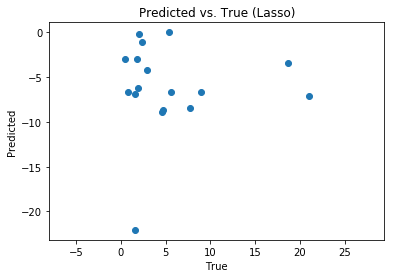

In [212]:
plt.figure()


plt.scatter(Y_test, lasso_pred.reshape(-1,1))
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title('Predicted vs. True (Lasso)')
plt.axis('equal')
vec = np.linspace(0,40,10000)

#.scatter(lasso_pred.reshape(-1,1), Y_test - lasso_pred.reshape(-1,1))


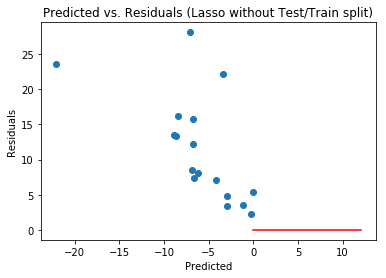

In [213]:
plt.scatter(lasso_pred.reshape(-1,1), (Y_test - lasso_pred).reshape(-1,1))
plt.plot([0,12],[0,0], 'r-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals (Lasso without Test/Train split)');

## No test/train split (Lasso)

In [224]:
X = np.array(shuffle.loc[:, ['ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, 'abs_lag'])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)

ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)


ssX = StandardScaler()
ssX.fit(X)
X_std = ss.transform(X)

In [225]:
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_std, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [226]:
grid.cv_results_

{'mean_fit_time': array([ 0.00049767,  0.00035   ,  0.00032835,  0.00026951,  0.00027637,
         0.00021482,  0.00028276,  0.00022154,  0.0002593 ,  0.0002326 ]),
 'mean_score_time': array([ 0.00018239,  0.00015893,  0.00013924,  0.00013943,  0.00012865,
         0.00012517,  0.00012774,  0.00012817,  0.00012693,  0.00014758]),
 'mean_test_score': array([-6.461688  , -7.57344126, -6.46165928, -7.57343395, -6.46137232,
        -7.57336237, -6.45850294, -7.57290323, -6.4288784 , -7.56954378]),
 'mean_train_score': array([-6.00948947, -7.24876349, -6.00947977, -7.24875108, -6.0093826 ,
        -7.2486276 , -6.00840899, -7.24739227, -5.9978549 , -7.23656756]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True False True False True False],
              mask = [False

In [238]:
grid.best_estimator_.score(X_std, y)

0.038192277001309449

In [228]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_std)
for true, pred in zip(y, lasso_pred):
    resid = true - pred
    print('pred, resid:', str(pred) + ', $' + str(resid))

pred, resid: 8.19392446002, $-3.58406146002
pred, resid: 7.28002565816, $1.72998334184
pred, resid: 9.12305501356, $-4.05298701356
pred, resid: 5.8435701531, $-2.3135411531
pred, resid: 7.37206783126, $9.05786416874
pred, resid: 6.37472207978, $1.99515092022
pred, resid: 8.65904235822, $-7.96910135822
pred, resid: 6.5959792694, $14.7140787306
pred, resid: 6.15480890811, $-5.50466290811
pred, resid: 7.85466036322, $10.8452906368
pred, resid: 8.2350553932, $-6.4350063932
pred, resid: 7.18676674285, $-6.28686474285
pred, resid: 6.96468085285, $-4.33455385285
pred, resid: 5.47125873799, $4.72869226201
pred, resid: 8.60645793969, $-5.78638993969
pred, resid: 9.61366399692, $-5.15370299692
pred, resid: 8.83750137696, $-8.45737437696
pred, resid: 3.5858630631, $-1.9957750631
pred, resid: 6.91416892476, $-5.69419892476
pred, resid: 8.20274084614, $-5.09263384614
pred, resid: 8.21078666188, $12.0992723381
pred, resid: 7.51805537631, $-7.38792837631
pred, resid: 7.60012815779, $-4.28030415779
pr

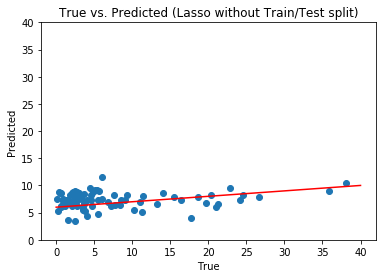

In [229]:
plt.scatter(y, lasso_pred.reshape(-1,1))
plt.plot([0,40], [6,10], 'r-')
plt.ylim(0,40)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs. Predicted (Lasso without Train/Test split)');

In [230]:

se = 0
for true, pred in zip(lasso_pred.reshape(-1,1), (y - lasso_pred).reshape(-1,1)):
    se += (true - pred)**2
mse = se / len(y)
mse

array([ 117.95877471])

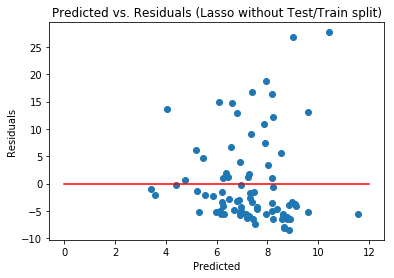

In [231]:
plt.scatter(lasso_pred.reshape(-1,1), (y - lasso_pred).reshape(-1,1))
plt.plot([0,12],[0,0], 'r-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs. Residuals (Lasso without Test/Train split)');

(0, 30)

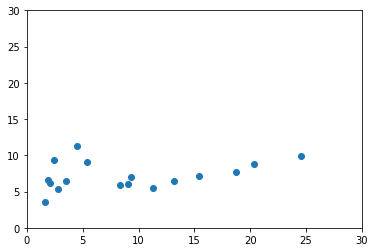

In [177]:
plt.scatter(Y_test, lasso_pred.reshape(-1,1))
plt.xlim(0,30)
plt.ylim(0,30)

# SGD

In [171]:
np.random.seed(42)
shuffle = feature_set1.sample(frac=1)

In [172]:
X = np.array(shuffle.loc[:, ['ss_econ', 'ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, 'abs_lag'])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2)

ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)


ssX = StandardScaler()
ssX.fit(X)
X_std = ss.transform(X)

In [173]:
#model = SGDRegressor(max_iter=5000, alpha=1)
#model.fit(X_train_std, Y_train)

model = SGDRegressor(max_iter=5000, learning_rate='constant')
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'fit_intercept': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_std, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=5000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [174]:
grid.cv_results_

{'mean_fit_time': array([ 0.01929045,  0.01319613,  0.01263738,  0.01325316,  0.01168585,
         0.01266432,  0.01194072,  0.01388569,  0.01336923,  0.01331935]),
 'mean_score_time': array([ 0.00032396,  0.00021195,  0.00016112,  0.00021682,  0.00014119,
         0.00016465,  0.00021281,  0.00046825,  0.00024939,  0.00026126]),
 'mean_test_score': array([-6.74714558, -7.84633471, -6.85809887, -7.86107991, -6.84492544,
        -7.85002736, -6.72461129, -7.78428659, -6.70385613, -7.70244616]),
 'mean_train_score': array([-5.97967151, -7.4234653 , -5.99582483, -7.44191463, -5.9971171 ,
        -7.45262045, -6.01653148, -7.42529929, -5.95926639, -7.40957682]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.0001 0.0001 0.001 0.001 0.01 0.01 0.1 0.1],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_fit_intercept': masked_array(data = [True False True False True False True False True False],
              mask = [False

In [175]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_std)
for true, pred in zip(Y_test, lasso_pred):
    resid = true - pred
    print('pred, resid:', str(pred) + ', $' + str(resid))

pred, resid: 6.65896068551, $-4.76882368551
pred, resid: 9.86849874341, $14.6515212566
pred, resid: 6.50999765882, $-3.00999765882
pred, resid: 9.06228978075, $-3.65213378075
pred, resid: 5.31718641621, $-2.53740141621
pred, resid: 8.82551957914, $11.4845394209
pred, resid: 5.44220701668, $5.84783198332
pred, resid: 11.3249656094, $-6.86500460942
pred, resid: 3.52054249889, $-1.93045449889
pred, resid: 6.47566532268, $6.74430567732
pred, resid: 5.92767142932, $2.44220157068
pred, resid: 7.11690604684, $8.31302595316
pred, resid: 9.28792963012, $-6.87777363012
pred, resid: 6.11289098215, $-4.05283198215
pred, resid: 6.99651640203, $2.30353159797
pred, resid: 7.66568197188, $11.0342690281
pred, resid: 5.98957528725, $3.02043371275


(0, 30)

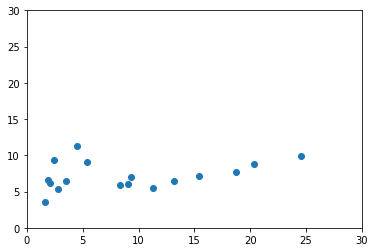

In [176]:
plt.scatter(Y_test, lasso_pred.reshape(-1,1))
plt.xlim(0,30)
plt.ylim(0,30)

# BASIC LR CV

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


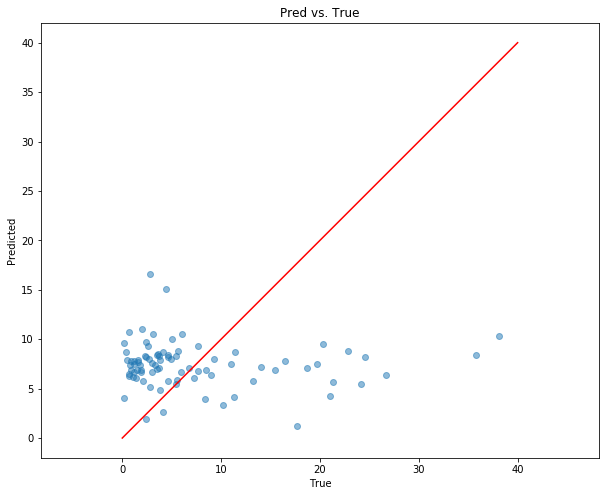

In [63]:
X = np.array(shuffle.loc[:, ['ss_econ', 'ss_day', 'releases', 'weighted']])
y = np.array(shuffle.loc[:, ['abs_lag']])
X_ones = np.c_[np.ones(X.shape[0]), X]
lr = LinearRegression()
scores = cross_val_score(lr, X_ones, y, cv=10, scoring=make_scorer(mean_squared_error))
y_pred = cross_val_predict(lr, X_ones, y, cv=10)

plt.figure(figsize=(10,8))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([0,40], [0,40], 'r-')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.axis('equal')
plt.title('Pred vs. True')
plt.show()

In [64]:
print(scores, np.mean(scores))

[  60.23401874   79.85874547   48.42952133   23.37182218  240.26418107
   32.09110644  171.21909276   19.9357738    18.56019072   48.24629273] 74.221074524
